# Laborator 12

Documentati-va depsre algoritmii de recomandare (collaborative recommendations) si, folosind un set de date de la [GroupLens](https://grouplens.org/datasets/) - exceptand MovieLens - efectuati recomandari de obiecte (carti etc.) pentru un utilizator in functie de: scorurile (rating-urile) date de utilizator si scorurile date de alti utilizatori. 

Testati cel putin 2 variante de rezolvare si comparati rezultatele obtinute. 


Bibliografie selectiva:

1. [Collaborative Filtering: A Tutorial](https://www.cs.cmu.edu/~wcohen/collab-filtering-tutorial.ppt)
1. Capitolul 2 "Making recommendations" din "Programming Collective Intelligence", Toby Segaran, O'Reilly Press, 2007
1. [Collaborative Filtering](http://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-datSc3-colFil.pdf)
1. [Recommendation Using Matrix Factorization](https://medium.com/@paritosh_30025/recommendation-using-matrix-factorization-5223a8ee1f4)

Predarea temei se va face in ultimul laborator din semestru.


In [26]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False,encoding='latin-1')
users.columns=['userID', 'Location', 'Age']
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [28]:
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False,encoding='latin-1')
ratings.columns=['userID','ISBN','bookRating']
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [29]:
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False,encoding='latin-1')
books.columns=['ISBN','bookTitle','bookAuthor','yearOfPublication','publisher','imageUrlS','ImageUrlM','ImageUrlL']
books.head()

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,ImageUrlM,ImageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Books dataset 

In [30]:
# image URLs columns do not seem to be required for analysis, and hence these can be dropped off
books=books.drop(['imageUrlS','ImageUrlM','ImageUrlL'], axis=1)
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [31]:
# check the data types for each of the columns, and correct the missing & discrepant entries
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

In [32]:
#verificare valori unice
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [33]:
#corectare erori in setul de date
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]
books.loc[books.ISBN == '0789466953', 'yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953', 'bookAuthor'] = 'James Buckley'
books.loc[books.ISBN == '0789466953', 'publisher'] = 'DK Publishing Inc'
books.loc[books.ISBN == '0789466953', 'bookTitle'] = 'DK Readers: Creating the X-Men, How Comic Books Come To Life (Level 4: Proficient Readers)'

books.loc[books.ISBN == '078946697X', 'yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X', 'bookAuthor'] = 'Michael Teitelbaum'
books.loc[books.ISBN == '078946697X', 'publisher'] = 'DK Publishing Inc'
books.loc[books.ISBN == '078946697X', 'bookTitle'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'

In [34]:
books.loc[books.yearOfPublication == 'Gallimard',:]
books.loc[books.ISBN == '2070426769', 'yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769', 'bookAuthor'] = 'Jean-Marie Gustave'
books.loc[books.ISBN == '2070426769', 'publisher'] = 'Gallimard'
books.loc[books.ISBN == '2070426769', 'bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers'"

In [35]:
#cateva valori string sev ortransforma in numerice; "coerce"-> valorile invalide se vor seta ca NaN
books.yearOfPublication.unique()
books.yearOfPublication = pd.to_numeric(books.yearOfPublication, errors='coerce')

In [36]:
# dataset was built in 2004, assuming all the years after 2006 are invalid keeping a margin of two years in case 
#dataset may have been updated. For all the invalid entries (including 0), I will convert these to NaNs, 
#and then replace them with mean values of remaining years.

books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0), 'yearOfPublication'] = np.NAN
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

In [37]:
# handled two NaN values by replacing them with ‘other’
books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [38]:
books.loc[(books.ISBN == '193169656X'), 'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'), 'publisher'] = 'other'

### User dataset 

In [39]:
users.dtypes

userID        int64
Location     object
Age         float64
dtype: object

In [40]:
# age column has a NaN and some very high values
# ages below 5 and above 90 do not make much sense, and hence, these are being replaced with NaNs
# all the NaNs are then replaced with mean value of Age, and its data type is set as int.
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [41]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan
users.Age = users.Age.fillna(users.Age.mean())
users.Age = users.Age.astype(np.int32)

In [42]:
print(sorted(users.Age.unique()))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


### Ratings dataset

In [43]:
# ratings dataset should have userID and ISBN which exist in respective tables, users and books.
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings_new = ratings_new[ratings_new.userID.isin(users.userID)]

In [44]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

In [60]:
# the explicit ratings represented by 1–10 and implicit ratings represented by 0 will have to be segregated now
# we will be using only explicit ratings
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

In [61]:
users_exp_ratings = users[users.userID.isin(ratings_explicit.userID)]
users_imp_ratings = users[users.userID.isin(ratings_implicit.userID)]

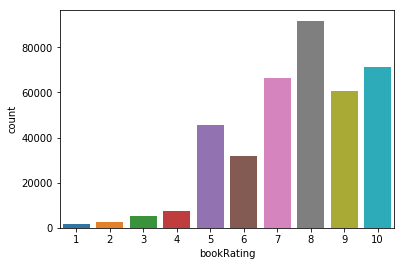

In [62]:
# countplot of bookRating indicates that rating 8 has been rated highest number of times
sns.countplot(data=ratings_explicit, x='bookRating')
plt.show()

### Popularity based recommendation 

In [63]:
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
top10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
print('Following books are recommended')
top10.merge(books, left_index = True, right_on = 'ISBN')

Following books are recommended


,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


### Collaborative Filtering 

In [65]:
# considering users who have rated at least 100 books and books which have at least 100 ratings to reduce the dataset size
counts1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 100].index)]
counts = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts[counts >= 100].index)]
print(ratings_explicit)


         userID        ISBN  bookRating
1456     277427  002542730X          10
1458     277427  003008685X           8
1461     277427  0060006641          10
1465     277427  0060542128           7
1474     277427  0061009059           9
1477     277427  0062507109           8
1483     277427  0132220598           8
1488     277427  0140283374           6
1490     277427  014039026X           8
1491     277427  0140390715           7
1494     277427  0141439742           8
1497     277427  0152050167          10
1501     277427  0201000822          10
1506     277427  0310435706          10
1509     277427  0312944691           8
1522     277427  0316776963           8
1543     277427  0345413903          10
1554     277427  0375408886           9
1560     277427  0375751513           9
1564     277427  0380702843           8
1570     277427  0380791978           9
1571     277427  038081904X           9
1578     277427  0385424736           9
1581     277427  0385486804           9


In [50]:
# generate user-item ratings matrix from the ratings table
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
ratings_matrix.head()

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
#since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings
#setting data type
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [52]:
ratings_matrix.head()

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# training the recommendation system
#setting global variables
global metric,k
k=10
metric='cosine' # similarity metric

### 1. User-based Recommendation system 

In [66]:
#This function finds k similar users given the user_id and ratings matrix 
#These similarities are same as obtained via using pairwise_distances
"""Se gasesc useri similari, in functie de raiting urile acordate"""
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities,indices

In [67]:
#This function predicts rating for specified user-item combination based on user-based approach
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    #print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

### 2. Item-based Recommendation system 

In [68]:
#This function finds k similar items given the item_id and ratings matrix

def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]
    ratings=ratings.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

In [69]:
#This function predicts the rating for specified user-item combination based on item-based approach
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings) #similar users based on correlation coefficients
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below //code has been validated without the code snippet below, below snippet is to avoid negative
    #predictions which might arise in case of very sparse datasets when using correlation metric
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10

    #print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))      
    
    return prediction

### Recommend books for users based on ratings

In [70]:
def recommendItem(user_id, ratings, select, metric=metric):
    prediction = []
    if(select == 'item'):
        for i in range(ratings.shape[1]):
            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                prediction.append(predict_itembased(user_id, str(ratings.columns[i]) ,ratings, metric))
            else:
                prediction.append(-1) #for already rated items
    elif(select == 'user'):
        for i in range(ratings.shape[1]):
            if (ratings[str(ratings.columns[i])][user_id] !=0): #not rated already
                prediction.append(predict_userbased(user_id, str(ratings.columns[i]) ,ratings, metric))
            else:
                prediction.append(-1) #for already rated items
    prediction = pd.Series(prediction)
    prediction = prediction.sort_values(ascending=False)
    recommended = prediction[:10]
    print("As per {0} approach....Following books are recommended...".format(select))
    for i in range(len(recommended)):
        print("{0}. {1}".format(i+1,books.bookTitle[recommended.index[i]].encode('utf-8')))

In [71]:
recommendItem(4385, ratings_matrix, select='item')

As per item approach....Following books are recommended...
1. b'My Wicked Wicked Ways'
2. b'Fair Peril'
3. b'Wolfpointe'
4. b'A Nest of Ninnies'
5. b'A Bitter Legacy'
6. b'A Hymn Before Battle'
7. b'Thomas the Rhymer'
8. b'Gatherer of Clouds (Initiate Brother Duology)'
9. b'Wege zum Ruhm: 13 Hilfestellungen f\xc3\x83\xc2\xbcr junge K\xc3\x83\xc2\xbcnstler und 1 Warnung'
10. b"Love In Bloom's"
